In [63]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, average_precision_score,
                             confusion_matrix, f1_score)
from sklearn.model_selection import (StratifiedKFold, permutation_test_score,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [64]:
data = pd.read_csv('50_Startups.csv')
data.head()


,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [65]:
data.isna().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

***
Drop rows where entries are 0
***

In [66]:
data = data.drop(index=data[(data['Marketing Spend'] <= 0) | (data['Administration'] <= 0) |  (data['R&D Spend'] <= 0)].index)

<AxesSubplot:xlabel='Profit', ylabel='Count'>

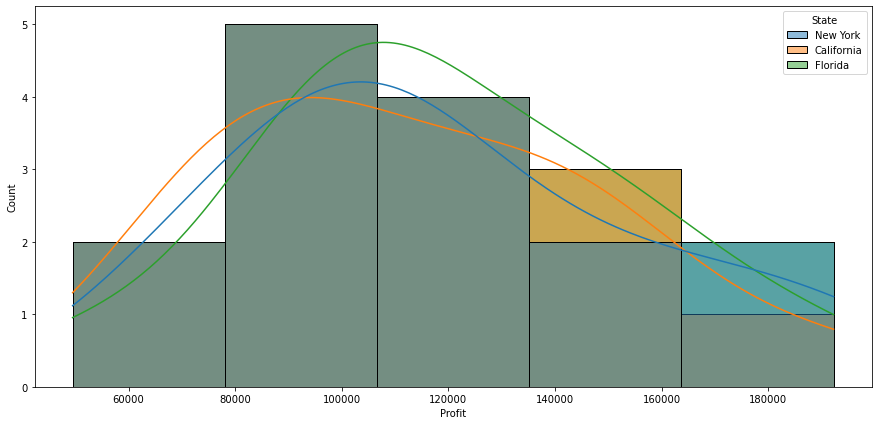

In [67]:
fig, ax = plt.subplots(figsize=(15,7))
sns.histplot(ax = ax, x='Profit', data=data, bins=5, hue='State', kde=True)

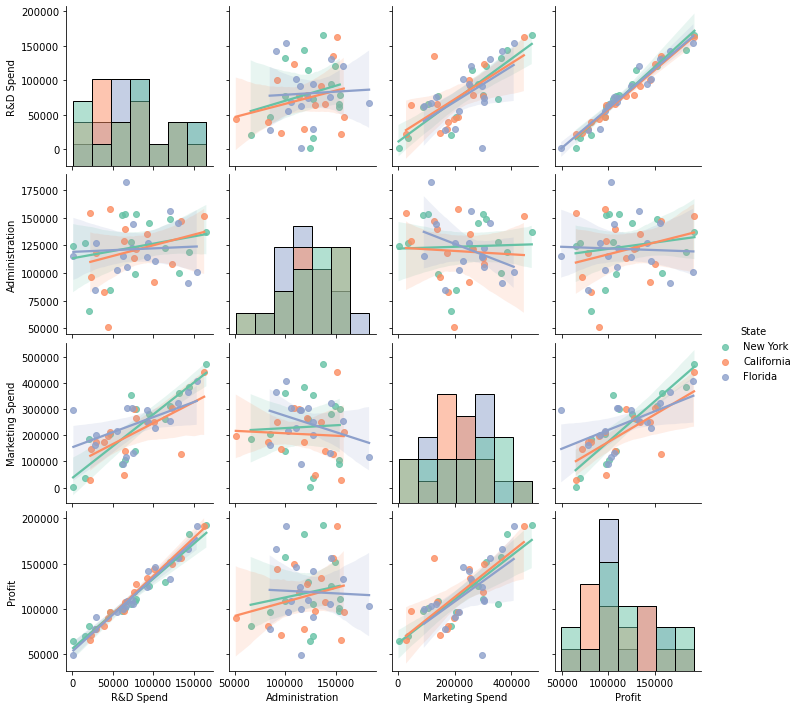

In [68]:
g = sns.pairplot(data, kind = 'reg', hue="State", palette="Set2", diag_kind="hist", height=2.5)

***
## R&D Spend and Marketing Spend has high correlation with profit.
## Admistration does not seem to have a strong correlation
## can be confirmed with a correlation table below
***

In [69]:
data.corr()

,R&D Spend,Administration,Marketing Spend,Profit
R&D Spend,1.000000,0.196068,0.708253,0.977703
Administration,0.196068,1.000000,-0.085831,0.135076
Marketing Spend,0.708253,-0.085831,1.000000,0.732277
Profit,0.977703,0.135076,0.732277,1.000000


***
## Lets check the expenses per state
***

In [70]:
outer_data = data.groupby('State').sum()
pct_data = outer_data.drop(['Profit'], axis=1).values
pct_data = data / data.sum(axis=1) * 100 # get percentages for spends for each state as aginst total spend
outer_data

C:\Users\vikas\anaconda3\envs\Python_3_7\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,R&D Spend,Administration,Marketing Spend,Profit
State,,,,
California,1099180.46,1800279.90,3058022.74,1709146.85
Florida,1291584.26,1948302.36,3957176.82,1900384.39
New York,1208354.31,1860981.74,3490882.27,1775409.32


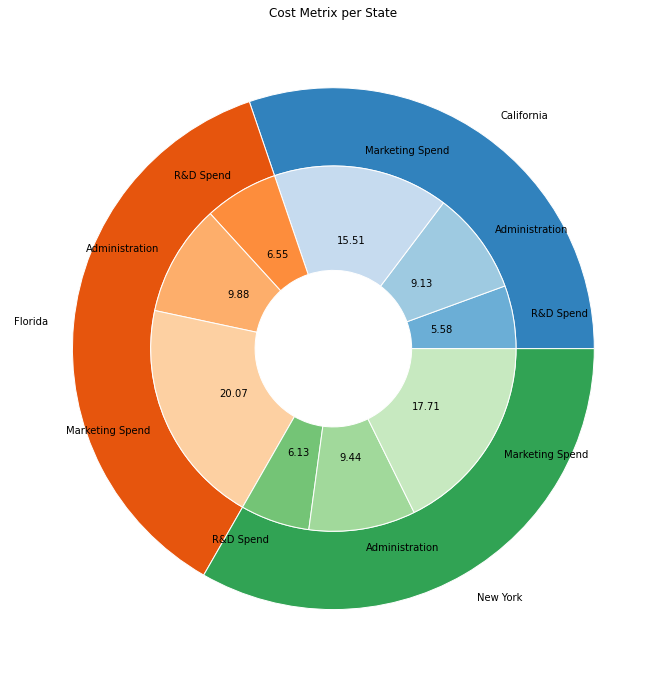

In [71]:
fig, ax = plt.subplots(figsize=(24,12))

size = 0.3

# outer_data = (100 * outer_data / outer_data.sum()).round(2)
# outer_data
inner_labels = outer_data.drop(['Profit'], axis=1).columns.values
inner_labels = np.concatenate((inner_labels, inner_labels, inner_labels))


cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 3,  # color fading blue
                              5, 6, 7,  # color fading orange
                              9, 10, 11])) # color fading

ax.pie(outer_data.drop(['Profit'],axis=1).sum(axis=1).values, radius=1, colors=outer_colors, labels=outer_data.index.values,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(outer_data.drop(['Profit'],axis=1).values.flatten(), radius=1-size, colors=inner_colors, labels = inner_labels, autopct='%.2f',
       wedgeprops=dict(width=size+0.1, edgecolor='w'))

ax.set(aspect="equal", title='Cost Metrix per State')
plt.show()

In [101]:
X = data.drop(['Profit', 'State'], axis=1)
y = data['Profit']


In [102]:
X.head(20)

,R&D Spend,Administration,Marketing Spend
0,165349.20,136897.80,471784.10
1,162597.70,151377.59,443898.53
2,153441.51,101145.55,407934.54
3,144372.41,118671.85,383199.62
4,142107.34,91391.77,366168.42
5,131876.90,99814.71,362861.36
6,134615.46,147198.87,127716.82
7,130298.13,145530.06,323876.68
8,120542.52,148718.95,311613.29
9,123334.88,108679.17,304981.62


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
X_train.head()

,R&D Spend,Administration,Marketing Spend
6,134615.46,147198.87,127716.82
25,64664.71,139553.16,137962.62
33,55493.95,103057.49,214634.81
20,76253.86,113867.30,298664.47
17,94657.16,145077.58,282574.31


In [107]:
# scaling
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
scalar = scalar.fit(X_train)
X_train = scalar.transform(X_train)

X_test = scalar.transform(X_test)

In [113]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [115]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print('Test scores: \n')
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test,y_pred_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred_test)))
print('R2:', r2_score(y_test,y_pred_test))

print('\n\nTrain scores: \n')
print('MAE:', mean_absolute_error(y_train,y_pred_train))
print('MSE:', mean_squared_error(y_train,y_pred_train))
print('RMSE:', np.sqrt(mean_squared_error(y_train,y_pred_train)))
print('R2:', r2_score(y_train,y_pred_train))

Test scores: 

MAE: 7816.551090568207
MSE: 84693001.78446265
RMSE: 9202.880080956322
R2: 0.9465361254771489


Train scores: 

MAE: 5164.938191521536
MSE: 41137364.563311115
RMSE: 6413.84163846529
R2: 0.9650159552087177


***
Simple Logistic Regression gives good result on train and test on R2 score
### Choosing R2 score for deployment
***